## Load packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Load data

In [2]:
# Assuming the CSV file is named 'comments.csv'
data = pd.read_csv('deidentified_survey_results_llm.csv')
data = data[:100000]

# Extract relevant columns
text_data = data['short_comment']
labels = data['pro_repeal']

# Basic data cleaning (if necessary)
# For example, removing any rows with missing values in the relevant columns
text_data = text_data.dropna()
labels = labels[text_data.index]

# If labels need to be converted (True/False to 1/0, etc.)
labels = labels.astype(int)  # Converting boolean to integer if necessary

<ipython-input-2-bd2592021beb>:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('deidentified_survey_results_llm.csv')


In [3]:
# Preprocessing function
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # Join words back to string
    clean_text = ' '.join(words)
    return clean_text

In [4]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_tfidf = tfidf_vectorizer.fit_transform(text_data)

# Labels
y = labels

In [5]:
# Dimensionality Reduction
svd = TruncatedSVD(n_components=5)  # Adjust n_components as needed
X_reduced = svd.fit_transform(X_tfidf)


In [6]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)


In [7]:
# Logistic Regression with L2 regularization
logistic_regression = LogisticRegression(penalty='l2', C=0.01, random_state=42)
logistic_regression.fit(X_train, y_train)


# Predictions
y_pred_lr = logistic_regression.predict(X_test)

# Evaluation
print("Logistic Regression Model")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))


Logistic Regression Model
              precision    recall  f1-score   support

           0       0.86      0.96      0.91     11550
           1       0.94      0.78      0.85      8450

    accuracy                           0.89     20000
   macro avg       0.90      0.87      0.88     20000
weighted avg       0.89      0.89      0.88     20000

[[11137   413]
 [ 1866  6584]]


In [8]:
# Initialize the SVM model with C=0.01
svm_model = SVC(C=0.01, kernel='linear', random_state=42)

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print("SVM Model with C=0.01")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))



SVM Model with C=0.01
              precision    recall  f1-score   support

           0       0.85      0.96      0.91     11550
           1       0.94      0.77      0.85      8450

    accuracy                           0.88     20000
   macro avg       0.90      0.87      0.88     20000
weighted avg       0.89      0.88      0.88     20000

[[11144   406]
 [ 1918  6532]]


In [9]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=5, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Model")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


Random Forest Model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11550
           1       1.00      1.00      1.00      8450

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

[[11540    10]
 [   13  8437]]


In [10]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation and check scores
cv_scores_lr = cross_val_score(logistic_regression, X_train, y_train, cv=5)
cv_scores_svm = cross_val_score(svm_model, X_train, y_train, cv=5)
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5)

print("Logistic Regression Cross-Validation Accuracy: {:.2f} (+/- {:.2f})".format(cv_scores_lr.mean(), cv_scores_lr.std() * 2))
print("SVM Cross-Validation Accuracy: {:.2f} (+/- {:.2f})".format(cv_scores_svm.mean(), cv_scores_svm.std() * 2))
print("Random Forest Cross-Validation Accuracy: {:.2f} (+/- {:.2f})".format(cv_scores_rf.mean(), cv_scores_rf.std() * 2))


Logistic Regression Cross-Validation Accuracy: 0.88 (+/- 0.00)
SVM Cross-Validation Accuracy: 0.88 (+/- 0.00)
Random Forest Cross-Validation Accuracy: 1.00 (+/- 0.00)


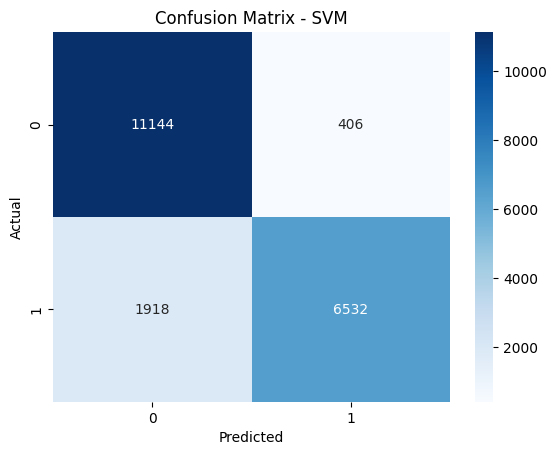

In [11]:
import seaborn as sns

# Confusion Matrix for SVM
conf_matrix = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Assuming you have predictions from each model
y_pred_lr = logistic_regression.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# If you are working with binary classification and want to use AUC-ROC
y_pred_prob_lr = logistic_regression.predict_proba(X_test)[:, 1]
y_pred_prob_svm = svm_model.decision_function(X_test)  # Use decision_function for SVM
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Precision
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')

# Recall
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')

# F1 Score
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# AUC-ROC (only applicable for binary classification)
auc_roc_lr = roc_auc_score(y_test, y_pred_prob_lr)
auc_roc_svm = roc_auc_score(y_test, y_pred_prob_svm)
auc_roc_rf = roc_auc_score(y_test, y_pred_prob_rf)

# Print the results
print("Logistic Regression: Accuracy = {:.2f}, Precision = {:.2f}, Recall = {:.2f}, F1 = {:.2f}, AUC-ROC = {:.2f}".format(
    accuracy_lr, precision_lr, recall_lr, f1_lr, auc_roc_lr))

print("SVM: Accuracy = {:.2f}, Precision = {:.2f}, Recall = {:.2f}, F1 = {:.2f}, AUC-ROC = {:.2f}".format(
    accuracy_svm, precision_svm, recall_svm, f1_svm, auc_roc_svm))

print("Random Forest: Accuracy = {:.2f}, Precision = {:.2f}, Recall = {:.2f}, F1 = {:.2f}, AUC-ROC = {:.2f}".format(
    accuracy_rf, precision_rf, recall_rf, f1_rf, auc_roc_rf))


Logistic Regression: Accuracy = 0.89, Precision = 0.89, Recall = 0.89, F1 = 0.88, AUC-ROC = 0.98
SVM: Accuracy = 0.88, Precision = 0.89, Recall = 0.88, F1 = 0.88, AUC-ROC = 0.98
Random Forest: Accuracy = 1.00, Precision = 1.00, Recall = 1.00, F1 = 1.00, AUC-ROC = 1.00


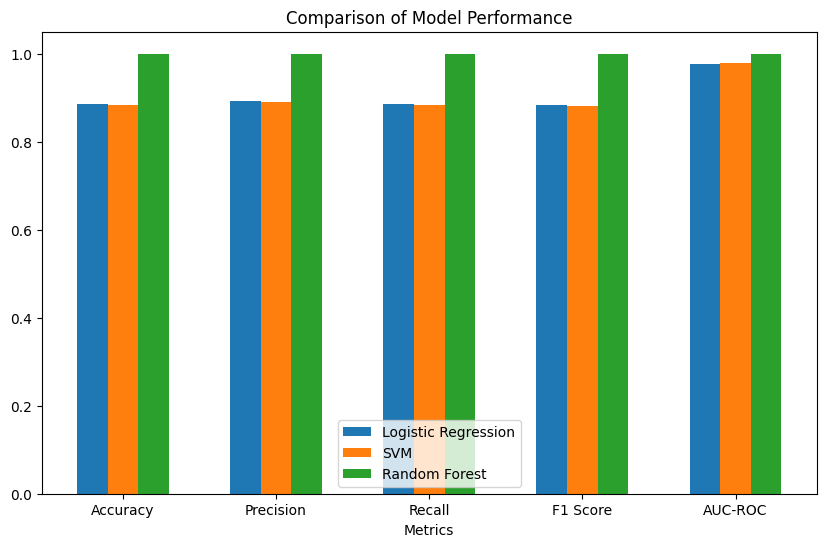

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for each model
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
lr_metrics = [accuracy_lr, precision_lr, recall_lr, f1_lr, auc_roc_lr]
svm_metrics = [accuracy_svm, precision_svm, recall_svm, f1_svm, auc_roc_svm]
rf_metrics = [accuracy_rf, precision_rf, recall_rf, f1_rf, auc_roc_rf]

x = np.arange(len(metrics))  # label locations
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, lr_metrics, width, label='Logistic Regression')
rects2 = ax.bar(x, svm_metrics, width, label='SVM')
rects3 = ax.bar(x + width, rf_metrics, width, label='Random Forest')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()


## Pre-processing

## Sentiment Analysis

sentiment = sid.polarity_scores(clean_comment)['compound']

## Save result to output csv

In [14]:
# Save the processed data with sentiment to a new CSV file
output_file_path = 'comments_with_sentiment.csv'
data.to_csv(output_file_path, index=False)


## Text Analysis

In [15]:
# Common patterns or trends in comments
from collections import Counter
import matplotlib.pyplot as plt

In [16]:
from textblob import TextBlob

# Function to analyze sentiment
def analyze_sentiment(comment):
    analysis = TextBlob(comment)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to create the sentiment_label column
data['sentiment_label'] = data['short_comment'].apply(analyze_sentiment)

# Verify that the sentiment_label column has been created
print(data.head())

      docid  campaign                  submitted  \
0  19970698         3  2017-08-11T14:57:52+00:00   
1  20235884         3  2017-08-11T15:09:48+00:00   
2  16906326         3  2017-08-04T20:03:40+00:00   
3  20626870         3  2017-08-11T19:46:40+00:00   
4  20354907         3  2017-08-11T16:14:38+00:00   

                         email_hash   email_domain  \
0  ed33934cc5701a337e210e61d5c12567      yahoo.com   
1  212ce60ccc6d3f0afed35e2d4d5c1050      gmail.com   
2  07ef30726e18a5672f8cac9c2c45c72e  sbcglobal.net   
3  4b6479817123ced072a67e425d683fd6      yahoo.com   
4  71e22da0855795acdb733cd0018ba95a      yahoo.com   

                                       short_comment email_valid  \
0  In 2015, Chairman Tom Wheelers Federal Commun...        True   
1  In 2015, Chairman Tom Wheelers Federal Commun...        True   
2  In 2015, Chairman Tom Wheelers Federal Commun...        True   
3  In 2015, Chairman Tom Wheelers Federal Commun...        True   
4  In 2015, Chairman T

In [17]:
# Analyze comments in support of the policy
supportive_comments = data[data['pro_repeal'] == True]
non_supportive_comments = data[data['pro_repeal'] == False]

print("Supportive Comments Sentiment Distribution:")
print(supportive_comments['sentiment_label'].value_counts())

print("\nNon-Supportive Comments Sentiment Distribution:")
print(non_supportive_comments['sentiment_label'].value_counts())

Supportive Comments Sentiment Distribution:
sentiment_label
positive    26550
negative    11490
neutral      3983
Name: count, dtype: int64

Non-Supportive Comments Sentiment Distribution:
sentiment_label
positive    42434
negative    12067
neutral      3476
Name: count, dtype: int64


In [18]:
from collections import Counter

# Use the short_comment column directly
supportive_words = ' '.join(supportive_comments['short_comment']).split()
common_supportive_words = Counter(supportive_words).most_common(50)

non_supportive_words = ' '.join(non_supportive_comments['short_comment']).split()
common_non_supportive_words = Counter(non_supportive_words).most_common(50)

# Display common words
print("\nCommon words in supportive comments:")
print(common_supportive_words)

print("\nCommon words in non-supportive comments:")
print(common_non_supportive_words)



Common words in supportive comments:
[('the', 132454), ('and', 56976), ('to', 45136), ('of', 30245), ('a', 29578), ('in', 24693), ('The', 18306), ('internet', 16099), ('like', 16087), ('regulations', 15519), ('FCC', 14836), ('is', 14747), ('Internet', 14746), ('regulatory', 14703), ('rules', 14019), ('I', 12907), ('for', 12612), ('government', 12265), ('internet.', 12033), ('by', 12000), ('as', 11333), ('an', 10791), ('that', 10671), ('control', 9437), ('over', 9433), ('Silicon', 9306), ('Valley', 9306), ('monopolies', 9306), ('Chairman', 9292), ('Federal', 9097), ('Communications', 9097), ('Commission', 8951), ('In', 8836), ("Obama's", 8746), ('2015,', 8649), ('Net', 8153), ("FCC's", 8150), ('was', 8000), ('Title', 7657), ('Obama', 7401), ('under', 7343), ('federal', 7330), ('investment', 7324), ('scheme', 7082), ('have', 6892), ('hurting', 6703), ('(FCC)', 6684), ('broadband', 6682), ('innovation', 6673), ('it', 6164)]

Common words in non-supportive comments:
[('the', 121615), ('to

In [19]:
# Combine common words into a single DataFrame
common_words = []
for word, count in common_supportive_words:
    common_words.append({'word': word, 'count': count, 'supportive': 'True'})
for word, count in common_non_supportive_words:
    common_words.append({'word': word, 'count': count, 'supportive': 'False'})

common_words_df = pd.DataFrame(common_words)


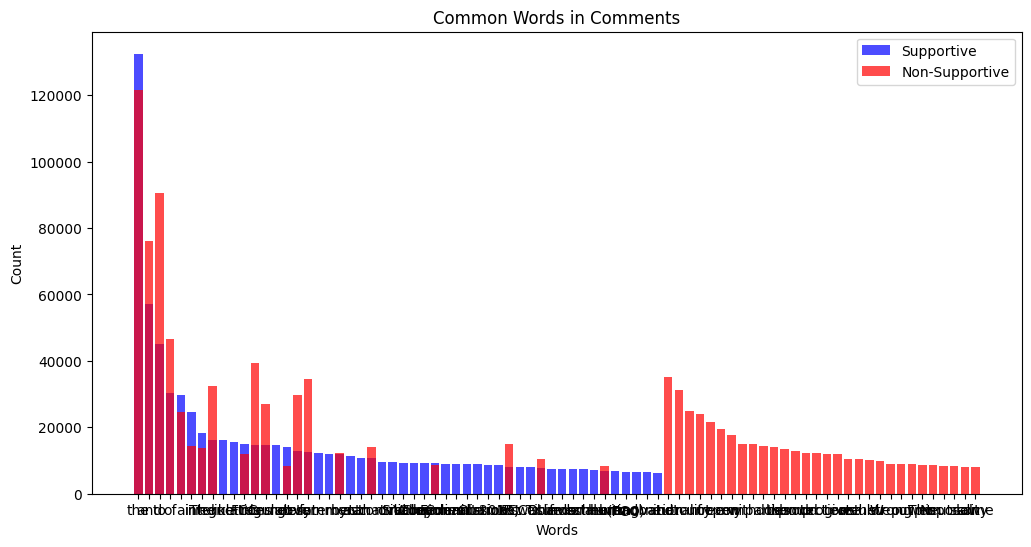

In [20]:
import matplotlib.pyplot as plt

# Plotting common words
supportive_df = pd.DataFrame(common_supportive_words, columns=['word', 'count'])
non_supportive_df = pd.DataFrame(common_non_supportive_words, columns=['word', 'count'])

plt.figure(figsize=(12, 6))
plt.bar(supportive_df['word'], supportive_df['count'], color='blue', alpha=0.7, label='Supportive')
plt.bar(non_supportive_df['word'], non_supportive_df['count'], color='red', alpha=0.7, label='Non-Supportive')
plt.title('Common Words in Comments')
plt.xlabel('Words')
plt.ylabel('Count')
plt.legend()
plt.show()


## Save common words to output csv

In [21]:
# Save common words to CSV file
common_words_df.to_csv('common_words.csv', index=False)

In [22]:
# Assuming 'data' is your DataFrame and 'sentiment_label' is the column containing sentiment labels

# Overall sentiment distribution
sentiment_distribution = data['sentiment_label'].value_counts(normalize=True) * 100

# Sentiment distribution in supportive comments
supportive_comments = data[data['pro_repeal'] == True]
supportive_distribution = supportive_comments['sentiment_label'].value_counts(normalize=True) * 100

# Sentiment distribution in non-supportive comments
non_supportive_comments = data[data['pro_repeal'] == False]
non_supportive_distribution = non_supportive_comments['sentiment_label'].value_counts(normalize=True) * 100


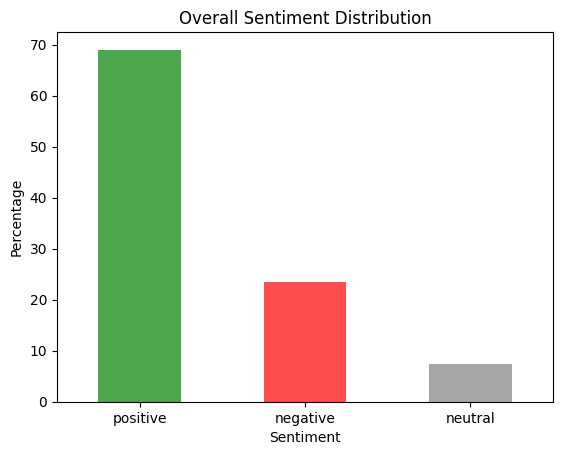

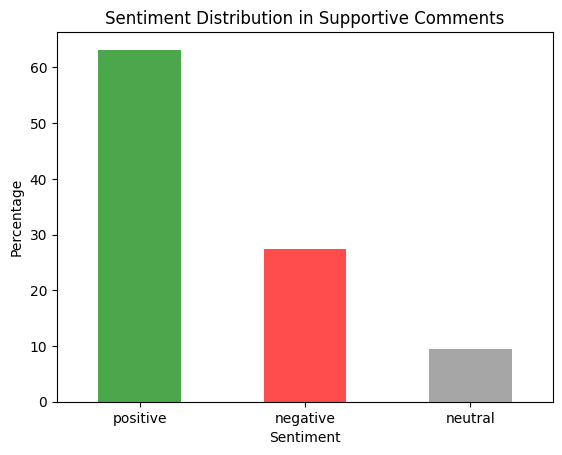

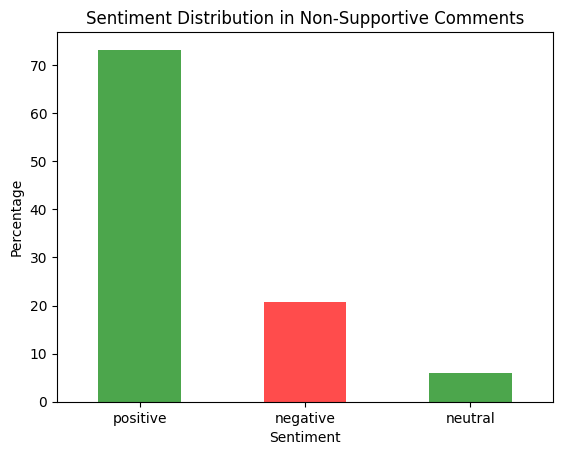

In [23]:
import matplotlib.pyplot as plt

# Plot sentiment distribution for all comments
sentiment_distribution.plot(kind='bar', color=['green', 'red', 'gray'], alpha=0.7)
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

# Plot sentiment distribution for supportive comments
supportive_distribution.plot(kind='bar', color=['green', 'red', 'gray'], alpha=0.7)
plt.title('Sentiment Distribution in Supportive Comments')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

# Plot sentiment distribution for non-supportive comments
non_supportive_distribution.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title('Sentiment Distribution in Non-Supportive Comments')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()


In [24]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6

output_notebook()

# Overall Sentiment Distribution
sentiment_labels = sentiment_distribution.index.tolist()
sentiment_values = sentiment_distribution.values.tolist()

# Adjusted code using `height` instead of `plot_height`
p = figure(x_range=sentiment_labels, height=350, title="Overall Sentiment Distribution",
           toolbar_location=None, tools="")

p.vbar(x=sentiment_labels, top=sentiment_values, width=0.9, color=factor_cmap('x', palette=Spectral6, factors=sentiment_labels))

p.xgrid.grid_line_color = None
p.y_range.start = 0
p.xaxis.axis_label = "Sentiment"
p.yaxis.axis_label = "Percentage"

show(p)


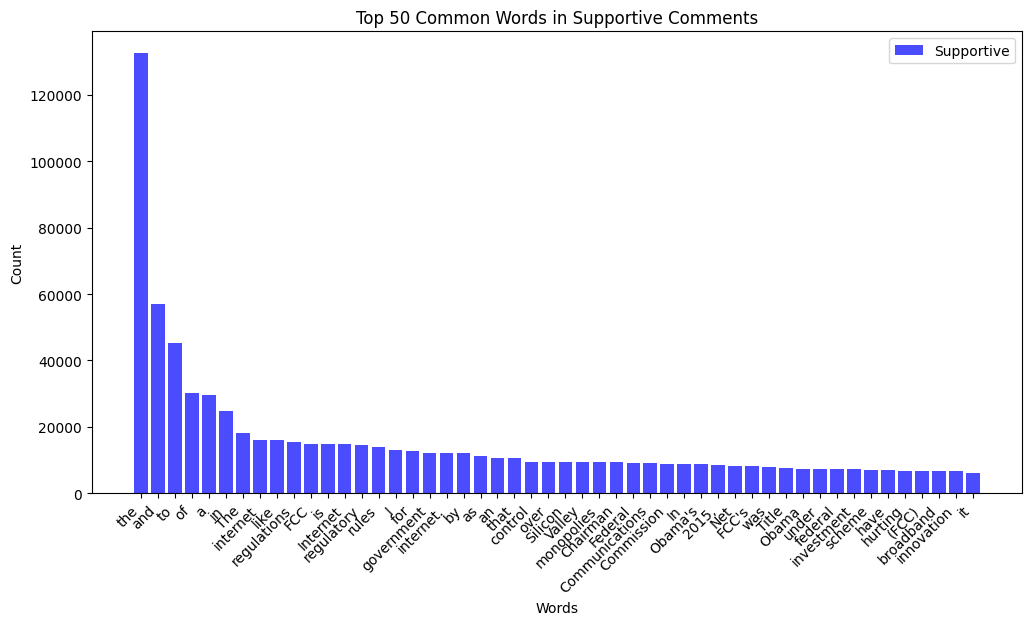

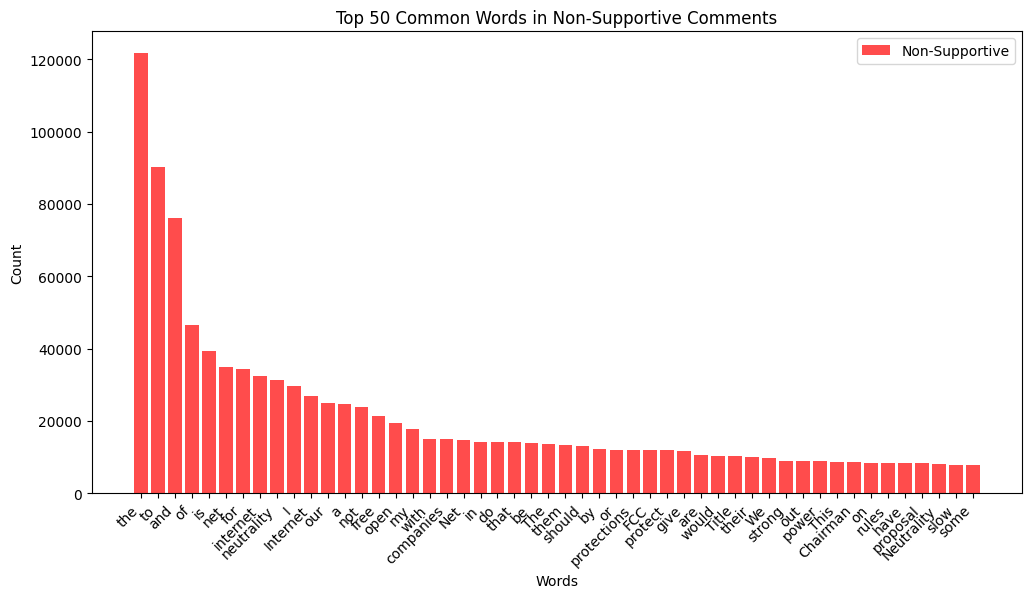

In [25]:
# Visualizing common words in supportive comments
supportive_df = pd.DataFrame(common_supportive_words, columns=['word', 'count'])
non_supportive_df = pd.DataFrame(common_non_supportive_words, columns=['word', 'count'])

plt.figure(figsize=(12, 6))
plt.bar(supportive_df['word'], supportive_df['count'], color='blue', alpha=0.7, label='Supportive')
plt.title('Top 50 Common Words in Supportive Comments')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

# Visualizing common words in non-supportive comments
plt.figure(figsize=(12, 6))
plt.bar(non_supportive_df['word'], non_supportive_df['count'], color='red', alpha=0.7, label='Non-Supportive')
plt.title('Top 50 Common Words in Non-Supportive Comments')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()


In [26]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource

output_notebook()

# Prepare data for Bokeh
supportive_source = ColumnDataSource(supportive_df)
non_supportive_source = ColumnDataSource(non_supportive_df)

# Adjust the height and width to make the chart larger
chart_height = 750
chart_width = 1000

# Plot for supportive comments
p_supportive = figure(x_range=supportive_df['word'], height=chart_height, width=chart_width,
                      title="Top 50 Common Words in Supportive Comments",
                      toolbar_location=None, tools="")

p_supportive.vbar(x='word', top='count', width=0.9, source=supportive_source, legend_label="Supportive",
                  line_color='white', fill_color='blue')

p_supportive.xgrid.grid_line_color = None
p_supportive.y_range.start = 0
p_supportive.xaxis.major_label_orientation = "vertical"

show(p_supportive)

# Plot for non-supportive comments
p_non_supportive = figure(x_range=non_supportive_df['word'], height=chart_height, width=chart_width,
                          title="Top 50 Common Words in Non-Supportive Comments",
                          toolbar_location=None, tools="")

p_non_supportive.vbar(x='word', top='count', width=0.9, source=non_supportive_source, legend_label="Non-Supportive",
                      line_color='white', fill_color='red')

p_non_supportive.xgrid.grid_line_color = None
p_non_supportive.y_range.start = 0
p_non_supportive.xaxis.major_label_orientation = "vertical"

show(p_non_supportive)


## Leading questions

* To what extent is the stakeholder feedback positive or negative?
* What are the most supportive and opposed perspectives?
* What are the main themes?
* What are the best examples of supportive, opposed and moderate perspectives?
* What are the practical suggestions and recommendations?

In [27]:
# Sentiment distribution across all comments
sentiment_distribution = data['sentiment_label'].value_counts(normalize=True) * 100
print("Sentiment Distribution (in %):")
print(sentiment_distribution)

# Distribution for supportive and non-supportive comments
supportive_distribution = supportive_comments['sentiment_label'].value_counts(normalize=True) * 100
non_supportive_distribution = non_supportive_comments['sentiment_label'].value_counts(normalize=True) * 100

print("\nSupportive Comments Sentiment Distribution (in %):")
print(supportive_distribution)

print("\nNon-Supportive Comments Sentiment Distribution (in %):")
print(non_supportive_distribution)


Sentiment Distribution (in %):
sentiment_label
positive    68.984
negative    23.557
neutral      7.459
Name: proportion, dtype: float64

Supportive Comments Sentiment Distribution (in %):
sentiment_label
positive    63.179687
negative    27.342170
neutral      9.478143
Name: proportion, dtype: float64

Non-Supportive Comments Sentiment Distribution (in %):
sentiment_label
positive    73.191093
negative    20.813426
neutral      5.995481
Name: proportion, dtype: float64


In [28]:
# Most common supportive perspectives
supportive_perspectives = supportive_comments[supportive_comments['sentiment_label'] == 'positive']['short_comment']

# Most common opposed perspectives
opposed_perspectives = non_supportive_comments[non_supportive_comments['sentiment_label'] == 'negative']['short_comment']

# Display a sample of the most common perspectives
print("Sample of supportive perspectives:")
print(supportive_perspectives.sample(5, random_state=42))  # Adjust sample size as needed

print("\nSample of opposed perspectives:")
print(opposed_perspectives.sample(5, random_state=42))  # Adjust sample size as needed


Sample of supportive perspectives:
5578     Before leaving office, the Obama Administratio...
21770    In 2015, wealthy leftist billionaires and powe...
21003    In 2015, wealthy leftist billionaires and powe...
96844    In 2015, President Obama's FCC passed rules tr...
67426    Dear FCC,  I'm contacting you about the FCC's ...
Name: short_comment, dtype: object

Sample of opposed perspectives:
19320    The Open Internet rules (net neutrality) are e...
86065    Repealing net neutrality is a bad economic dec...
24231    Dear Ladies and Gentlemen. Net neutrality is a...
36521    Allowing broadband providers to throttle their...
73643    The Open Internet rules (net neutrality) are e...
Name: short_comment, dtype: object


In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the text
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(data['short_comment'])

# Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust the number of topics as needed
lda.fit(X)

# Display the top words for each topic
for index, topic in enumerate(lda.components_):
    print(f"Top 10 words for topic #{index}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Top 10 words for topic #0:
['want', 'urge', 'rules', 'power', 'open', 'slow', 'fcc', 'neutrality', 'net', 'internet']
Top 10 words for topic #1:
['regulatory', 'scheme', 'net', 'neutrality', 'fight', 'hurting', 'innovation', 'government', 'control', 'internet']
Top 10 words for topic #2:
['interests', 'title', 'users', 'rules', 'open', 'companies', 'free', 'net', 'neutrality', 'internet']
Top 10 words for topic #3:
['fcc', 'internet', 'strong', 'save', 'support', 'ii', 'protections', 'title', 'net', 'neutrality']
Top 10 words for topic #4:
['neutrality', '2015', 'federal', 'government', 'obama', 'like', 'regulations', 'rules', 'fcc', 'internet']


In [30]:
# Best examples of supportive perspectives
best_supportive = supportive_comments[supportive_comments['sentiment_label'] == 'positive']['short_comment'].sample(5, random_state=42)

# Best examples of opposed perspectives
best_opposed = non_supportive_comments[non_supportive_comments['sentiment_label'] == 'negative']['short_comment'].sample(5, random_state=42)

# For moderate perspectives (assuming neutral sentiment is used)
moderate_comments = data[data['sentiment_label'] == 'neutral']['short_comment'].sample(5, random_state=42)

# Display the examples
print("Best supportive perspectives:")
print(best_supportive)

print("\nBest opposed perspectives:")
print(best_opposed)

print("\nModerate perspectives:")
print(moderate_comments)


Best supportive perspectives:
5578     Before leaving office, the Obama Administratio...
21770    In 2015, wealthy leftist billionaires and powe...
21003    In 2015, wealthy leftist billionaires and powe...
96844    In 2015, President Obama's FCC passed rules tr...
67426    Dear FCC,  I'm contacting you about the FCC's ...
Name: short_comment, dtype: object

Best opposed perspectives:
19320    The Open Internet rules (net neutrality) are e...
86065    Repealing net neutrality is a bad economic dec...
24231    Dear Ladies and Gentlemen. Net neutrality is a...
36521    Allowing broadband providers to throttle their...
73643    The Open Internet rules (net neutrality) are e...
Name: short_comment, dtype: object

Moderate perspectives:
86195    I am commenting in support of Title II net neu...
63094    I support Net Neutrality backed by Title II ov...
1142     In 2015, Chairman Tom Wheelers Federal Commun...
88535    In 2015, Chairman Tom Wheelers Federal Commun...
76511    As an Interne

In [31]:
# Example approach: Extract sentences with certain keywords
suggestions_keywords = ['should', 'recommend', 'suggest', 'consider', 'improve']

practical_suggestions = data['short_comment'].apply(
    lambda comment: ' '.join([sentence for sentence in comment.split('.') if any(word in sentence for word in suggestions_keywords)])
)

# Filter non-empty suggestions
practical_suggestions = practical_suggestions[practical_suggestions != '']

# Display practical suggestions
print("Practical suggestions and recommendations:")
print(practical_suggestions.sample(5, random_state=42))  # Adjust sample size as needed


Practical suggestions and recommendations:
51848     It gives some of the biggest companies in the...
74101     They do not (and should not) have the right t...
35418     A free and open internet is the single greate...
39118                Internet speed should not be for sale
39711                Internet speed should not be for sale
Name: short_comment, dtype: object
